#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [100 for i in range(node_N)]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[5000,
 4900,
 4800,
 4700,
 4600,
 4500,
 4400,
 4300,
 4200,
 4100,
 4000,
 3900,
 3800,
 3700,
 3600,
 3500,
 3400,
 3300,
 3200,
 3100,
 3000,
 2900,
 2800,
 2700,
 2600,
 2500,
 2400,
 2300,
 2200,
 2100,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60761404731.24999

In [23]:
Irho[-49][0][0]

441458471931.25

In [24]:
Irho

array([[[4.65002472e+11, 4.04250480e+11, 4.04250480e+11],
        [4.04250480e+11, 4.65002472e+11, 4.04250480e+11],
        [4.04250480e+11, 4.04250480e+11, 4.65002477e+11]],

       [[4.41458472e+11, 3.80706480e+11, 3.80706480e+11],
        [3.80706480e+11, 4.41458472e+11, 3.80706480e+11],
        [3.80706480e+11, 3.80706480e+11, 4.41458477e+11]],

       [[4.18846814e+11, 3.58094822e+11, 3.58094822e+11],
        [3.58094822e+11, 4.18846814e+11, 3.58094822e+11],
        [3.58094822e+11, 3.58094822e+11, 4.18846819e+11]],

       [[3.97148664e+11, 3.36396672e+11, 3.36396672e+11],
        [3.36396672e+11, 3.97148664e+11, 3.36396672e+11],
        [3.36396672e+11, 3.36396672e+11, 3.97148668e+11]],

       [[3.76345185e+11, 3.15593194e+11, 3.15593194e+11],
        [3.15593194e+11, 3.76345185e+11, 3.15593194e+11],
        [3.15593194e+11, 3.15593194e+11, 3.76345190e+11]],

       [[3.56417544e+11, 2.95665552e+11, 2.95665552e+11],
        [2.95665552e+11, 3.56417544e+11, 2.95665552e+11],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[-0.78688461,  0.08671905,  0.61097661],
       [-0.41408055,  0.6598914 , -0.62696143],
       [-0.45754771, -0.74633983, -0.48334972]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.004119


In [43]:
Ret.shape

(50, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000707


In [47]:
C1(dx,dy,dz,Ret)

array([[ 9.01577264e-01, -1.36402911e+00, -7.56282412e-01,
        -1.36081025e+00, -5.81154513e-03,  2.86114768e-01,
        -4.21909916e-01, -2.78350027e-03, -1.01164975e-01,
        -6.40495735e-01, -2.90269952e-01, -2.91973271e+00,
        -9.37714201e-03, -1.93386872e-01, -1.34833210e+00,
         2.06904789e-07, -1.32610081e-01, -1.06864183e+00,
        -9.92492043e-02, -3.98541283e+00,  3.54487655e-02,
         1.22461001e-01, -3.00810989e+00, -1.18642134e-02,
         7.91506558e-01,  1.09233193e-01, -2.99295249e+00,
         3.59206975e-02, -6.60524645e-02,  2.11734308e-01,
         1.75605433e+00, -8.82556018e-01,  1.19828179e-01,
         2.79013794e-02,  4.56018062e-01,  1.43232962e-01,
        -2.37136437e-02, -3.49023693e+00, -8.89555198e-01,
        -1.44961119e+00, -5.58754670e-01, -9.02570663e-02,
        -1.75415854e-02,  1.38613659e-01,  5.60748211e-01,
         1.00551042e+00, -1.64626881e+00,  5.30170273e-01,
        -3.64018101e-01, -3.92229341e-02],
       [ 4.02

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[ 5.17418251e+03,  2.30888751e+03, -4.20873179e+03],
       [-7.82820936e+03, -2.49045795e+01, -2.81835034e+00],
       [-4.34033043e+03, -1.20035686e+04, -4.67461248e+03],
       [-7.80973618e+03,  1.55660032e+04,  2.74334380e+04],
       [-3.33526547e+01,  2.23954912e+04,  6.94646989e+02],
       [ 1.64202236e+03,  6.03859855e+03,  3.28327052e+03],
       [-2.42135533e+03, -5.69927603e+02, -2.75368611e+03],
       [-1.59746025e+01, -1.27870007e+03,  5.28338880e+02],
       [-5.80589227e+02, -2.00656629e+04,  2.32905815e+03],
       [-3.67582676e+03, -5.49233941e+02, -4.46817251e+02],
       [-1.66586911e+03, -7.90664267e+02, -1.33963074e+03],
       [-1.67564451e+04,  1.22959071e+04,  3.97610958e+03],
       [-5.38157362e+01, -1.14243388e+04,  7.02808188e+03],
       [-1.10985382e+03,  9.92410890e+03,  6.66698793e+03],
       [-7.73812369e+03,  6.79965501e+03, -5.87418564e+03],
       [ 1.18743360e-03, -3.76924539e+03, -8.09321121e+02],
       [-7.61053754e+02,  7.09951299e+03

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000304


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000345


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000140


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 8.91571307e-02,  4.47037438e-01,  2.04750531e+00],
       [ 2.41965204e-01, -4.72499824e-01,  1.17761575e-02],
       [-1.53746522e-03,  1.25323045e+00,  1.23257305e+00],
       [ 1.12389870e-01,  1.08748974e-02, -2.22244822e-03],
       [-1.10542746e+00,  9.33447754e-01,  2.87773018e-01],
       [ 1.61159138e-02, -1.55982919e-01,  5.65113213e-01],
       [ 4.14931755e-01,  1.96939403e+00, -1.58453064e+00],
       [ 1.01450343e+00,  1.40436963e+00,  7.42966058e-01],
       [-7.02433499e-01, -3.74170546e-01, -8.19374370e-01],
       [ 2.11220370e+00,  6.02670567e-01,  4.35808208e-01],
       [ 4.79375606e-01,  5.23401815e-01, -1.40643795e+00],
       [ 6.98957197e-01, -5.88065361e-01,  4.00848585e-01],
       [-7.31971598e-01,  8.90557019e-01,  5.50858711e-01],
       [-5.64357471e-01,  5.03531680e-01,  9.48149086e-01],
       [-6.43063131e-01, -4.53944993e-01,  4.31819639e-01],
       [ 4.00645947e-01,  8.27703278e-01, -4.13162828e-01],
       [ 3.27406057e-01, -6.28369728e-01

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000424


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002623


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.004541


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[-9.94272073e-01, -5.52463810e-01, -8.53131499e-01],
       [-7.62822828e-01,  2.59143819e+00, -2.60583912e-01],
       [-1.27975259e-01,  2.13121270e+00,  1.36631411e+00],
       [-4.97847715e-01, -6.42451203e-01,  3.37756531e-02],
       [ 6.48652508e-01,  9.74342633e-01,  6.30570005e-01],
       [-1.15387370e-01,  3.54142215e-01,  2.01448617e-02],
       [ 1.69538697e+00,  3.44554624e-01,  6.89547944e-02],
       [ 1.17382992e+00, -8.48114090e-01, -1.08117417e+00],
       [-5.87954533e-01,  8.87416089e-01,  2.16417525e-01],
       [ 2.32570733e-01, -3.60038368e-01,  1.06216198e+00],
       [-2.59624695e+00,  5.52881252e-01,  5.15810187e-01],
       [ 4.85657189e-01,  1.20011850e+00,  2.33433839e-01],
       [ 5.39694438e-01,  3.94352377e-01, -1.14519406e+00],
       [ 4.84005229e-01,  1.45104243e-01,  1.14981191e-02],
       [-2.31665234e-02,  5.36199917e-01,  4.73872114e-01],
       [ 5.31066593e-01,  7.71291103e-01, -5.26450155e-01],
       [ 7.99725982e-01,  3.62844233e+00

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [74]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.44301699e-02,  4.33467095e-03, -1.20651374e-04,
        -1.17331292e-04, -5.76351090e-03,  6.48293892e-03,
        -3.18886270e-02, -5.88055924e-03, -4.02707221e-03,
        -1.47063703e-03, -1.73445008e-02,  8.87123173e-03,
        -3.01144816e-03,  4.02853384e-03,  7.94970442e-03,
        -1.11267345e-02,  2.99017008e-04,  3.11496138e-02,
        -2.62920939e-02,  3.46720140e-03,  1.05253504e-02,
         2.18076635e-02, -1.46401368e-02,  9.72967747e-03,
        -1.26054610e-02, -2.78447211e-02,  1.39145830e-04,
        -4.72145258e-03, -1.02252202e-03, -1.11706706e-02,
         4.10411790e-04, -1.33660892e-02,  9.52671890e-03,
         7.11919131e-03, -1.19024453e-02,  5.66329544e-03,
         7.29101604e-05,  5.89272309e-03,  2.37001159e-02,
        -4.96651921e-04, -2.89907580e-02, -8.62070502e-03,
        -1.68099265e-02,  2.66251020e-03,  7.37718110e-03,
         4.55267578e-03,  1.41637577e-02,  2.77893285e-03,
        -8.48670380e-03, -1.11223979e-02],
       [-2.04

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.007578


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-7.37540311e-07,  4.81067528e-07, -1.03665514e-06,
         6.25857346e-09,  3.20245320e-07,  7.40582278e-07,
        -5.43128540e-07,  2.60616769e-06, -1.27220819e-07,
        -2.23756148e-06, -3.78964205e-08, -7.19985686e-07,
         1.15429185e-06,  6.25658048e-07,  9.93370241e-07,
        -1.34726949e-06,  1.17211368e-07,  4.65743155e-06,
        -3.84854471e-06,  4.30443233e-07, -4.35376973e-08,
        -1.25595038e-07, -2.11708454e-06,  3.38986489e-07,
        -1.72316414e-07, -1.41865560e-07,  2.03828585e-07,
        -3.69482128e-07,  3.57705087e-06, -1.84919459e-07,
         2.80877617e-06,  8.60128543e-07,  1.13172118e-06,
         3.16209957e-06,  2.23458533e-07, -2.67590398e-07,
        -1.11028978e-06,  1.96151042e-06,  2.64630511e-06,
        -4.43440820e-07, -4.26671226e-07, -1.83311960e-06,
        -1.57664362e-06,  1.99564708e-07,  9.08762989e-07,
         8.93204968e-08,  7.61815575e-07, -1.28071702e-06,
         1.69749882e-06, -8.09810717e-07],
       [ 6.47

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-5.17418251e+03,  7.82820936e+03,  4.34033043e+03,
         7.80973618e+03,  3.33526547e+01, -1.64202236e+03,
         2.42135533e+03,  1.59746025e+01,  5.80589227e+02,
         3.67582676e+03,  1.66586911e+03,  1.67564451e+04,
         5.38157362e+01,  1.10985382e+03,  7.73812369e+03,
        -1.18743360e-03,  7.61053754e+02,  6.13297171e+03,
         5.69594552e+02,  2.28724195e+04, -2.03441668e+02,
        -7.02807839e+02,  1.72636447e+04,  6.80891232e+01,
        -4.54248300e+03, -6.26893001e+02,  1.71766559e+04,
        -2.06150102e+02,  3.79077336e+02, -1.21515038e+03,
        -1.00780554e+04,  5.06501894e+03, -6.87697984e+02,
        -1.60126963e+02, -2.61710314e+03, -8.22018832e+02,
         1.36093406e+02,  2.00305882e+04,  5.10518747e+03,
         8.31936779e+03,  3.20671202e+03,  5.17988367e+02,
         1.00671754e+02, -7.95508495e+02, -3.21815302e+03,
        -5.77065841e+03,  9.44799258e+03, -3.04266519e+03,
         2.08911224e+03,  2.25101750e+02],
       [-2.30

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.007621


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-5.08508491e+03,  4.98700904e+07,  1.49447068e+06],
       [-1.25320055e+03, -1.79763609e+07,  3.06365026e+07],
       [ 8.38968214e+01, -2.71930549e+05, -5.75541113e+05],
       [ 3.57600449e+02,  4.32299819e+07, -4.68444808e+07],
       [ 8.50967920e+03, -3.52407533e+07, -5.07181579e+07],
       [ 4.77203308e+03, -5.08574108e+07,  2.65519916e+06],
       [ 1.00585264e+02, -9.63992173e+05, -5.20230615e+04],
       [ 1.88160949e+02, -2.00704601e+06,  1.06436076e+05],
       [-2.51357776e+03, -1.96829622e+07,  4.50749164e+07],
       [-1.34186610e+03,  4.18240391e+07, -2.82712710e+07],
       [-3.94963097e+03,  3.33428411e+05,  3.95638320e+07],
       [ 8.31368587e+03, -1.93360691e+07, -6.46438174e+07],
       [ 1.26769266e+02, -6.43306401e+04, -1.21622841e+06],
       [ 3.43964184e+03, -1.92625533e+07, -1.54820824e+07],
       [ 1.15396300e+04, -6.17463458e+07, -5.48183314e+07],
       [ 3.17046907e+03, -3.45748558e+07,  2.55005040e+06],
       [ 1.06683860e+01,  3.23993029e+05

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-5.95200402e+08,  1.49388144e+08, -4.98706797e+09],
       [ 8.28289860e+09,  3.06447026e+09,  1.79845605e+09],
       [ 2.54407374e+09, -5.73022479e+07,  2.74449055e+07],
       [-7.16866683e+09, -4.68515778e+09, -4.32370785e+09],
       [-6.29140008e+08, -5.07187807e+09,  3.52401305e+09],
       [-1.40178504e+10,  2.64132149e+08,  5.08435339e+09],
       [-1.41301182e+10, -6.60118809e+06,  9.50004063e+07],
       [ 2.38213453e+05,  1.06436312e+07,  2.00704624e+08],
       [-3.41483066e+09,  4.50715357e+09,  1.96795817e+09],
       [-1.50815082e+09, -2.82727640e+09, -4.18255321e+09],
       [-7.40936265e+07,  3.95637587e+09, -3.33501760e+07],
       [-5.04414133e+08, -6.46443168e+09,  1.93355698e+09],
       [-1.18065179e+10, -1.22791686e+08,  5.26427777e+06],
       [-1.61883865e+10, -1.54981089e+09,  1.92465276e+09],
       [-8.15670721e+09, -5.48264065e+09,  6.17382711e+09],
       [-6.26117731e+09,  2.54385183e+08,  3.45686576e+09],
       [ 8.94211489e+09, -4.22923669e+07

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000556


In [88]:
Re_b(Ret).shape

(50, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[ 1.95635646e+10,  3.89566215e+11,  1.02625574e+12],
        [-2.51026427e+09, -7.16585022e+10, -1.75361876e+10],
        [ 8.18750848e+10,  2.27069975e+11,  6.00111760e+11]],

       [[ 7.47665601e+10, -2.83809126e+10, -3.34968619e+10],
        [ 2.61283266e+11,  5.26615236e+10,  5.03625029e+10],
        [ 1.11941644e+12, -1.05890427e+10,  3.46381110e+11]],

       [[ 5.02144843e+11,  7.89472290e+10, -5.59798159e+11],
        [-6.07590122e+11, -3.18228902e+10,  5.70111746e+11],
        [ 1.35123643e+11,  5.91504679e+10, -8.34880658e+10]],

       [[ 2.60847395e+10,  1.60872096e+10, -5.51549130e+10],
        [ 9.21818686e+11,  2.06311370e+11,  1.98460574e+11],
        [ 4.56470330e+11,  3.41931330e+10,  8.33140579e+10]],

       [[ 6.42844253e+10,  1.17647948e+11,  3.13667837e+11],
        [ 3.19236630e+11,  3.11766259e+11,  7.40890315e+11],
        [ 1.23159574e+11,  2.02298805e+11,  3.19403617e+11]],

       [[ 2.59124566e+11,  3.16066626e+11,  5.59916246e+11],
        [ 1.78

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.000403


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002666


In [97]:
d_me_

array([[ 2.13157218e-03, -1.77509771e+01, -3.78024290e+00],
       [-7.91213377e-04,  1.52674225e+01, -7.27573823e+00],
       [-7.55140131e-05,  1.10861531e+01, -1.03239086e+01],
       [-1.18695557e-03,  4.08254417e+00,  7.90730469e+00],
       [ 3.04502745e-05, -1.09475469e+01,  1.06405076e+01],
       [-4.69673830e-04,  5.07122385e-01,  4.23727163e+00],
       [ 7.65359082e-06,  3.43863270e+01, -3.44653825e+01],
       [ 1.77281772e-03, -1.79092177e+01,  1.97113937e-03],
       [-1.83792282e-03,  6.99496503e+00,  1.15704952e+01],
       [ 2.83648955e-03, -2.84647878e+01, -1.86626489e-01],
       [-3.03303744e-03,  9.73823250e-01,  2.96644166e+01],
       [-2.32658595e-03, -1.86862801e+00,  2.53707779e+01],
       [-7.65346834e-05,  3.10157202e+01, -3.02441752e+01],
       [-7.76618159e-05,  8.15680996e+00, -7.37272090e+00],
       [-3.38543059e-05, -6.52239918e+00,  6.86470967e+00],
       [-9.76200267e-04,  8.92691990e+00,  9.33734508e-01],
       [-2.40791807e-05,  2.56653365e+01

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[-5.17418251e+03,  7.82820936e+03,  4.34033043e+03,
         7.80973618e+03,  3.33526547e+01, -1.64202236e+03,
         2.42135533e+03,  1.59746025e+01,  5.80589227e+02,
         3.67582676e+03,  1.66586911e+03,  1.67564451e+04,
         5.38157362e+01,  1.10985382e+03,  7.73812369e+03,
        -1.18743360e-03,  7.61053754e+02,  6.13297171e+03,
         5.69594552e+02,  2.28724195e+04, -2.03441668e+02,
        -7.02807839e+02,  1.72636447e+04,  6.80891232e+01,
        -4.54248300e+03, -6.26893001e+02,  1.71766559e+04,
        -2.06150102e+02,  3.79077336e+02, -1.21515038e+03,
        -1.00780554e+04,  5.06501894e+03, -6.87697984e+02,
        -1.60126963e+02, -2.61710314e+03, -8.22018832e+02,
         1.36093406e+02,  2.00305882e+04,  5.10518747e+03,
         8.31936779e+03,  3.20671202e+03,  5.17988367e+02,
         1.00671754e+02, -7.95508495e+02, -3.21815302e+03,
        -5.77065841e+03,  9.44799258e+03, -3.04266519e+03,
         2.08911224e+03,  2.25101750e+02],
       [-2.30

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [110]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [111]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

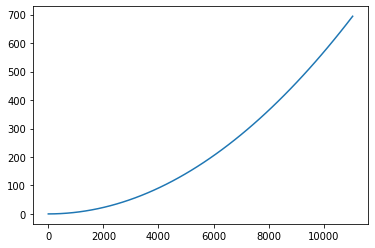

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
q0=root

In [121]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [122]:
# x0_

In [123]:
# z0

In [124]:
# z0_

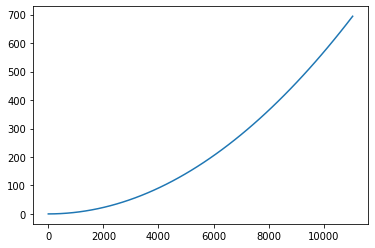

In [125]:
plt.plot(x0_, z0_)
plt.show()

In [126]:
# init=1
# for j in range(1,12):
#     if j==1:  
#         q0[(j-1)*node_N:j*node_N]=x0_
#     elif j==5:    
#         q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
# #         q0[(j-1)*node_N]=0
#     elif j==7:    
#         q0[(j-1)*node_N:j*node_N]=np.array([-0.00010522890316932987*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=np.array([6.952842745988619e-09*(i+1)/node_N*init for i in range(node_N)])
# #         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=np.array([0.00010649100253301569*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# # q0[9*node_N-1]=0.13  # here
# q0[7*node_N-1]= -0.00010522890316932987 # here
# q0[9*node_N-1]= 6.952842745988619e-09
# q0[11*node_N-1]=0.00010649100253301569  # here

### Vessle Simulation

In [127]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [128]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [129]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [130]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

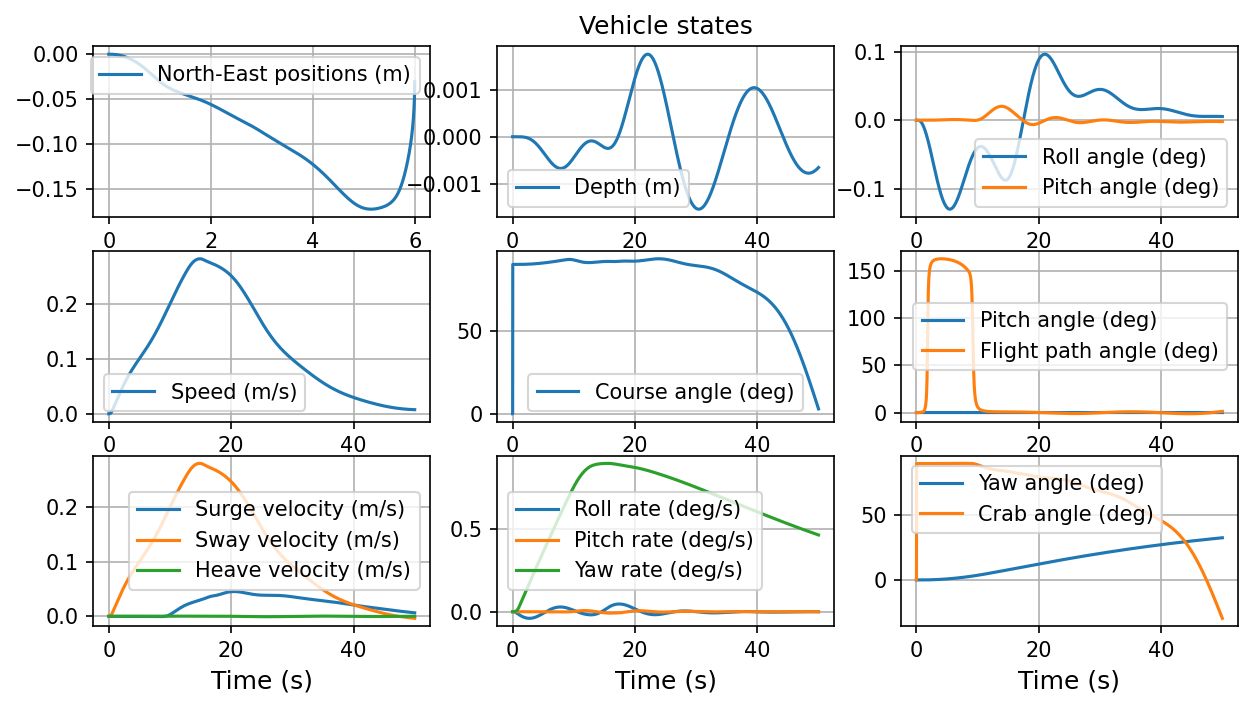

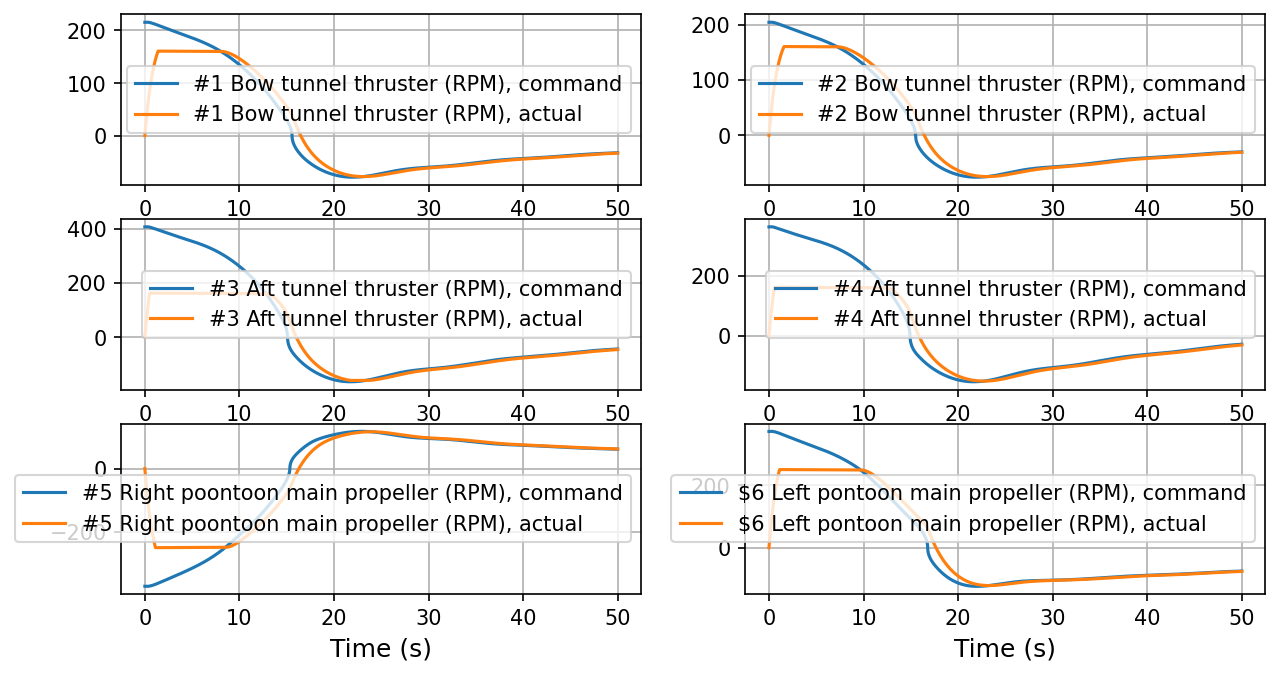

In [131]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [132]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

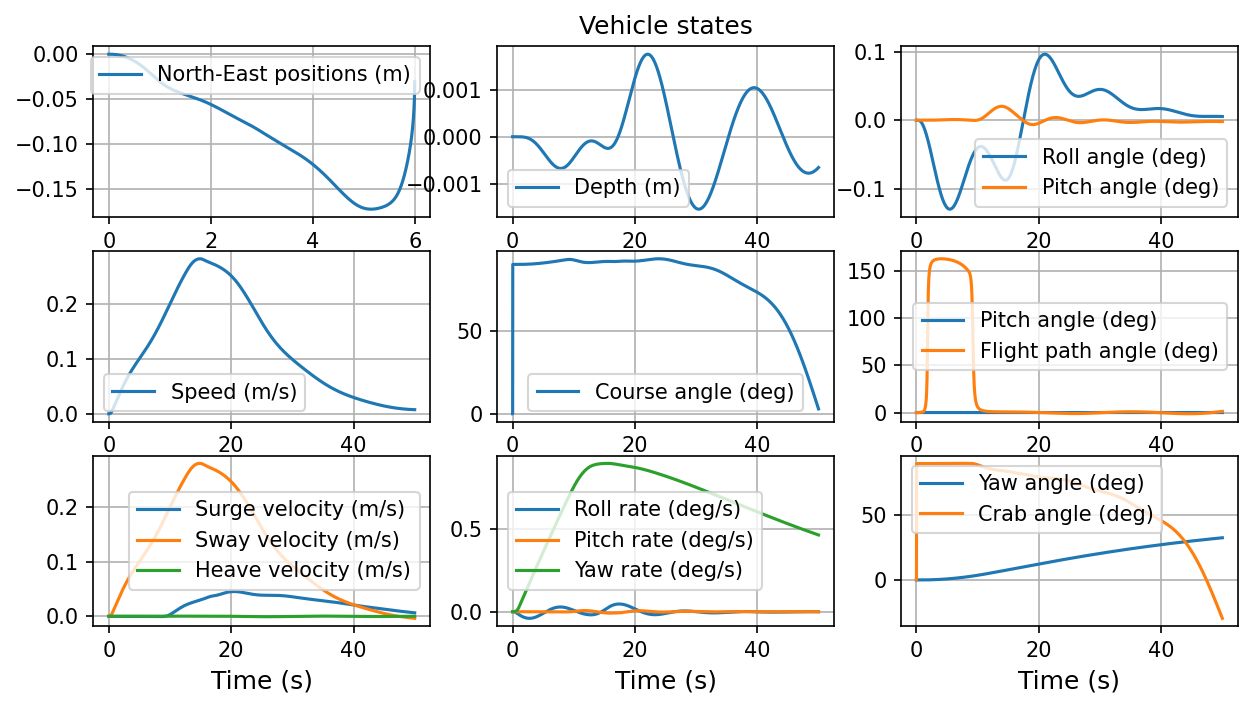

In [133]:
plotVehicleStates(simTime, simData, 3)

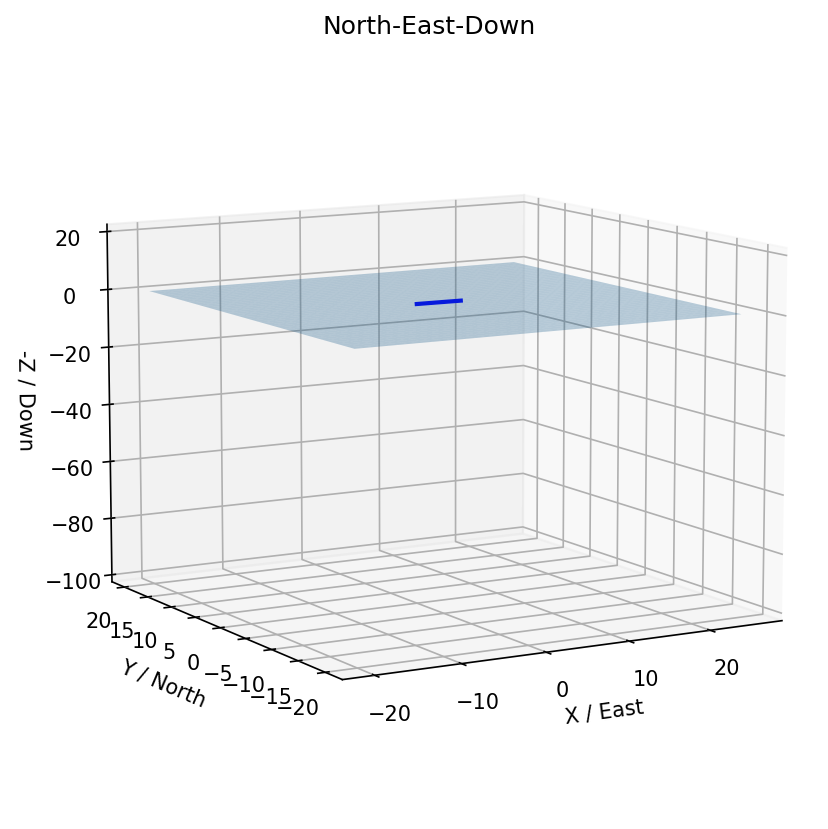

In [134]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [135]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [136]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [137]:
# Ws[0]*Ret[2]

In [138]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [139]:
idx=1/0.01

In [140]:
idx

100.0

In [141]:
ssa(simData[:, 3][int(idx)])

-0.00010522890316932987

In [142]:
ssa(simData[:, 4][int(idx)])

6.952842745988619e-09

In [143]:
ssa(simData[:, 5][int(idx)])

0.00010649100253301569

### Dynamics

In [144]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+1) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     force_schedule=1
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     print(tau_force)
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)
  
    Z= (
        Z1
        + Z2 
        +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll) 

#     lll=length_p   
    
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
#     print(cum_d_inv[0])
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho[12])
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
#                  ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################
#     print(B[49])
#     print()

#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111[-1])
    return A1111

In [145]:
# import scipy

In [146]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [147]:
# us=ode15s.integrate(10)

In [148]:
tspan = (0., 0.1)

In [149]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:31.127831


In [150]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init) and force_schedule 

# the main problem of the model is that it accelirates too much
# the hack increases the mass, the greater the mass the lesser the  acceleration
# the force_schedule affects the force, the lesser the force the lesser the  acceleration
# bc set conditions on how much force from the vessel should be applied to counteract the movement because of bc

# too fast acceleration leads to solution divergence in short amount of time

### Results

In [151]:
fin=us

In [152]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1610
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.61447725e-09, 5.22583852e-08, 2.23910663e-07,
       8.57952873e-07, 3.11951699e-06, 1.11108902e-05, 3.92880911e-05,
       1.38591697e-04, 4.88411929e-04, 1.31031798e-03, 2.13222404e-03,
       2.93931688e-03, 3.98399286e-03, 5.33700492e-03, 7.17028031e-03,
       9.18885763e-03, 1.12074349e-02, 1.28066670e-02, 1.44058990e-02,
       1.63030864e-02, 1.80589569e-02, 1.98148273e-02, 2.16813697e-02,
       2.34773884e-02, 2.51040897e-02, 2.66636614e-02, 2.83768781e-02,
       3.02578668e-02, 3.18792047e-02, 3.35005425e-02, 3.53314657e-02,
       3.72158136e-02, 3.87044467e-02, 4.01930799e-02, 4.20244489e-02,
       4.37306186e-02, 4.54367883e-02, 4.71887675e-02, 4.86303200e-02,
       5.00718725e-02, 5.18315000e-02, 5.34396883e-02, 5.50478766e-02,
       5.67448064e-02, 5.81018229e-02, 

In [153]:
t=fin.t

In [154]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


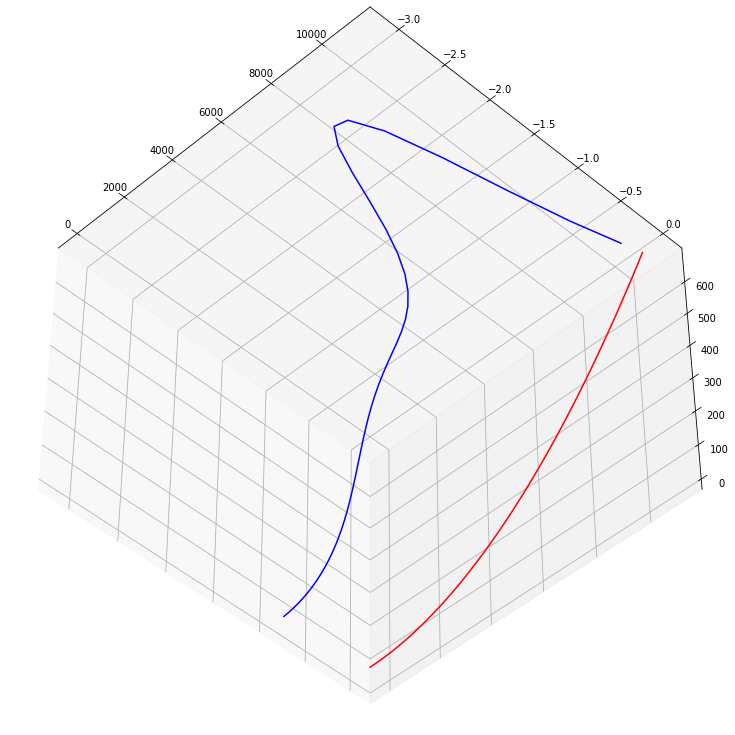

In [155]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [156]:
X,Y,Z

(array([-2.55242182e-01,  2.25203515e+02,  4.50674281e+02,  6.76152473e+02,
         9.01635907e+02,  1.12712345e+03,  1.35261451e+03,  1.57810880e+03,
         1.80360621e+03,  2.02910676e+03,  2.25461052e+03,  2.48011759e+03,
         2.70562806e+03,  2.93114198e+03,  3.15665932e+03,  3.38217987e+03,
         3.60770323e+03,  3.83322865e+03,  4.05875493e+03,  4.28428028e+03,
         4.50980206e+03,  4.73531659e+03,  4.96081896e+03,  5.18630286e+03,
         5.41176068e+03,  5.63718391e+03,  5.86256382e+03,  6.08789222e+03,
         6.31316190e+03,  6.53836648e+03,  6.76349985e+03,  6.98855525e+03,
         7.21352443e+03,  7.43839668e+03,  7.66315769e+03,  7.88778815e+03,
         8.11226188e+03,  8.33654378e+03,  8.56058781e+03,  8.78433679e+03,
         9.00772645e+03,  9.23069782e+03,  9.45322006e+03,  9.67531924e+03,
         9.89709684e+03,  1.01187172e+04,  1.03403570e+04,  1.05621381e+04,
         1.07840796e+04,  1.10043666e+04]),
 array([-0.95265123, -0.95900558, -0.9665711

In [157]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [158]:
us=fin.T

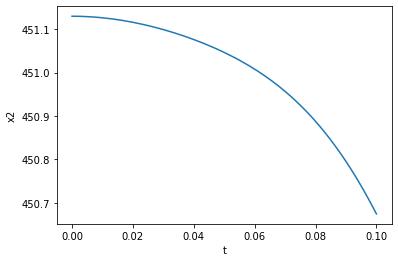

In [159]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

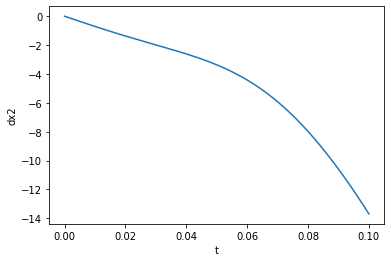

In [160]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

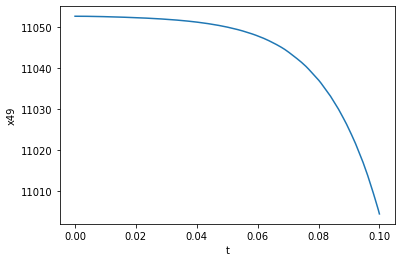

In [161]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

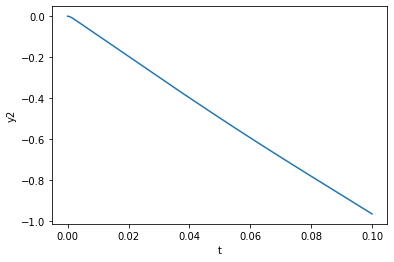

In [162]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

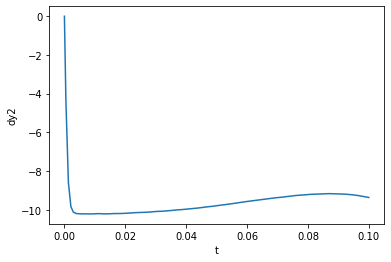

In [163]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

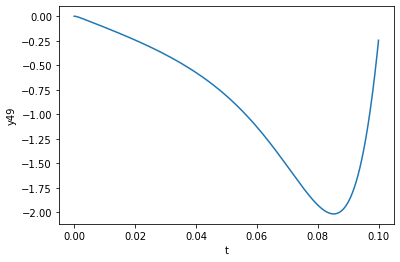

In [164]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

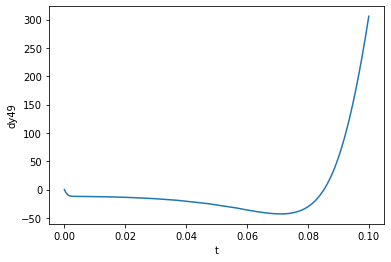

In [165]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

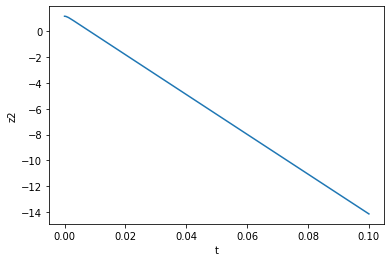

In [166]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

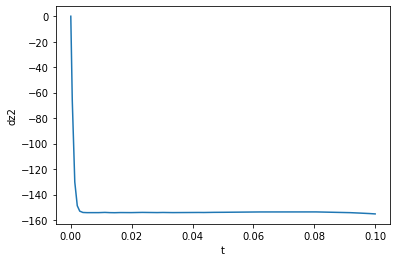

In [167]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

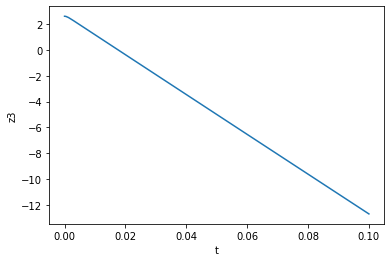

In [168]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

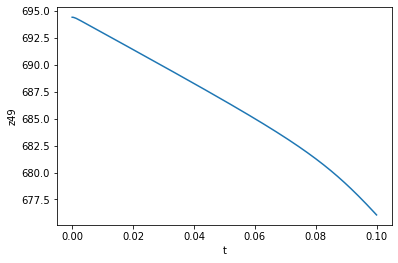

In [169]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

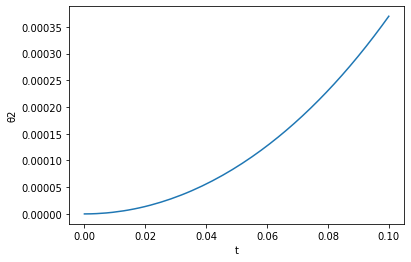

In [170]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

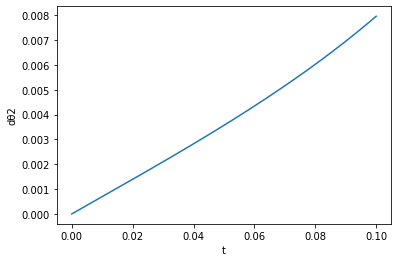

In [171]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

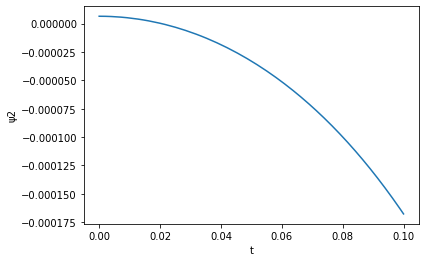

In [172]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

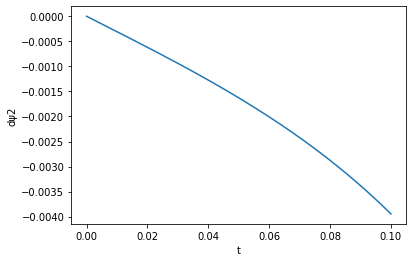

In [173]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()